In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from pyarrow import Table
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from source import *
from pathlib import Path
from itertools import cycle
import scienceplots

plt.style.use(['science','ieee', 'grid'])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams["figure.figsize"] = (12/1.5, 6/1.5) 

In [2]:
sig = ds.dataset(list(Path(f"sig_data/").glob("*.parquet")), format="parquet")
lep = ds.dataset(list(Path(f"halfleptonic/").glob("*.parquet")), format="parquet")

In [3]:
bsbs = ds.dataset(list(Path(f"gen_data/").glob("bsbs*.parquet")), format="parquet")
nonbsbs = ds.dataset(list(Path(f"gen_data/").glob("nonbsbs*.parquet")), format="parquet")
uds = ds.dataset(list(Path(f"gen_data/").glob("uds*.parquet")), format="parquet")

In [4]:
scanner = bsbs.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = Table.from_batches([batch])
    print(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'pmiss', 'cmpmiss', 'thetamiss',
       'cmthetamiss', 'fox', 'asymmetry', 'p0', 'theta_Bs', 'M0', 'recM2_Bs',
       'idec0', 'idec1', 'is0', 'N_KL', 'Miss_id_0', 'Miss_id_1', 'Bs_lik',
       'N_KS', 'theta_tau_0', 'p_tau_0', 'theta_tau_1', 'p_tau_1', 'tau_d_0_0',
       'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0', 'tau_last_z_1',
       'tau_last_r_1', 'Istau0', 'Istau1', 'Chi_sq_0', 'Chi_sq_1', 'dr0',
       'dr1', 'totalEnergyMC', 'E_gamma_in_ROE', 'correct_nu_0',
       'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1', 'lost_0',
       'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1',
       'PID_self_vs_1_tau1', 'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')


In [5]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012)
mask_M = (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask1 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 1) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask0 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 0) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))
mask_miss_id = pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_lost_Kpi = pc.field("lost_0") & pc.field("lost_1")
mask_KS_veto = (pc.field("N_KS") == 0) & (pc.field("N_KL") == 0)

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_11772\1173690368.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [6]:
from xgboost import XGBClassifier
import json
model = XGBClassifier()
model.load_model("output/bdt_model.json")
with open("output/columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [7]:
v1 = get_values(bsbs, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v2 = get_values(nonbsbs, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v3 = get_values(uds, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v4 = get_values(uds, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v5 = get_values(nonbsbs, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v6 = get_values(bsbs, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v1["marker"] = 1  # $B_S \to D(\ell \nu)\ell \nu$
v2["marker"] = 2  # nonbsbs
v3["marker"] = 3  # continuum
v4["marker"] = 4  # FEI missID
v5["marker"] = 5  # FEI missID
v6["marker"] = 6  # FEI missID

data = pd.concat([v1, v2, v3, v4, v5, v6], ignore_index=True)


Total data size: 0.02 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.01 MB


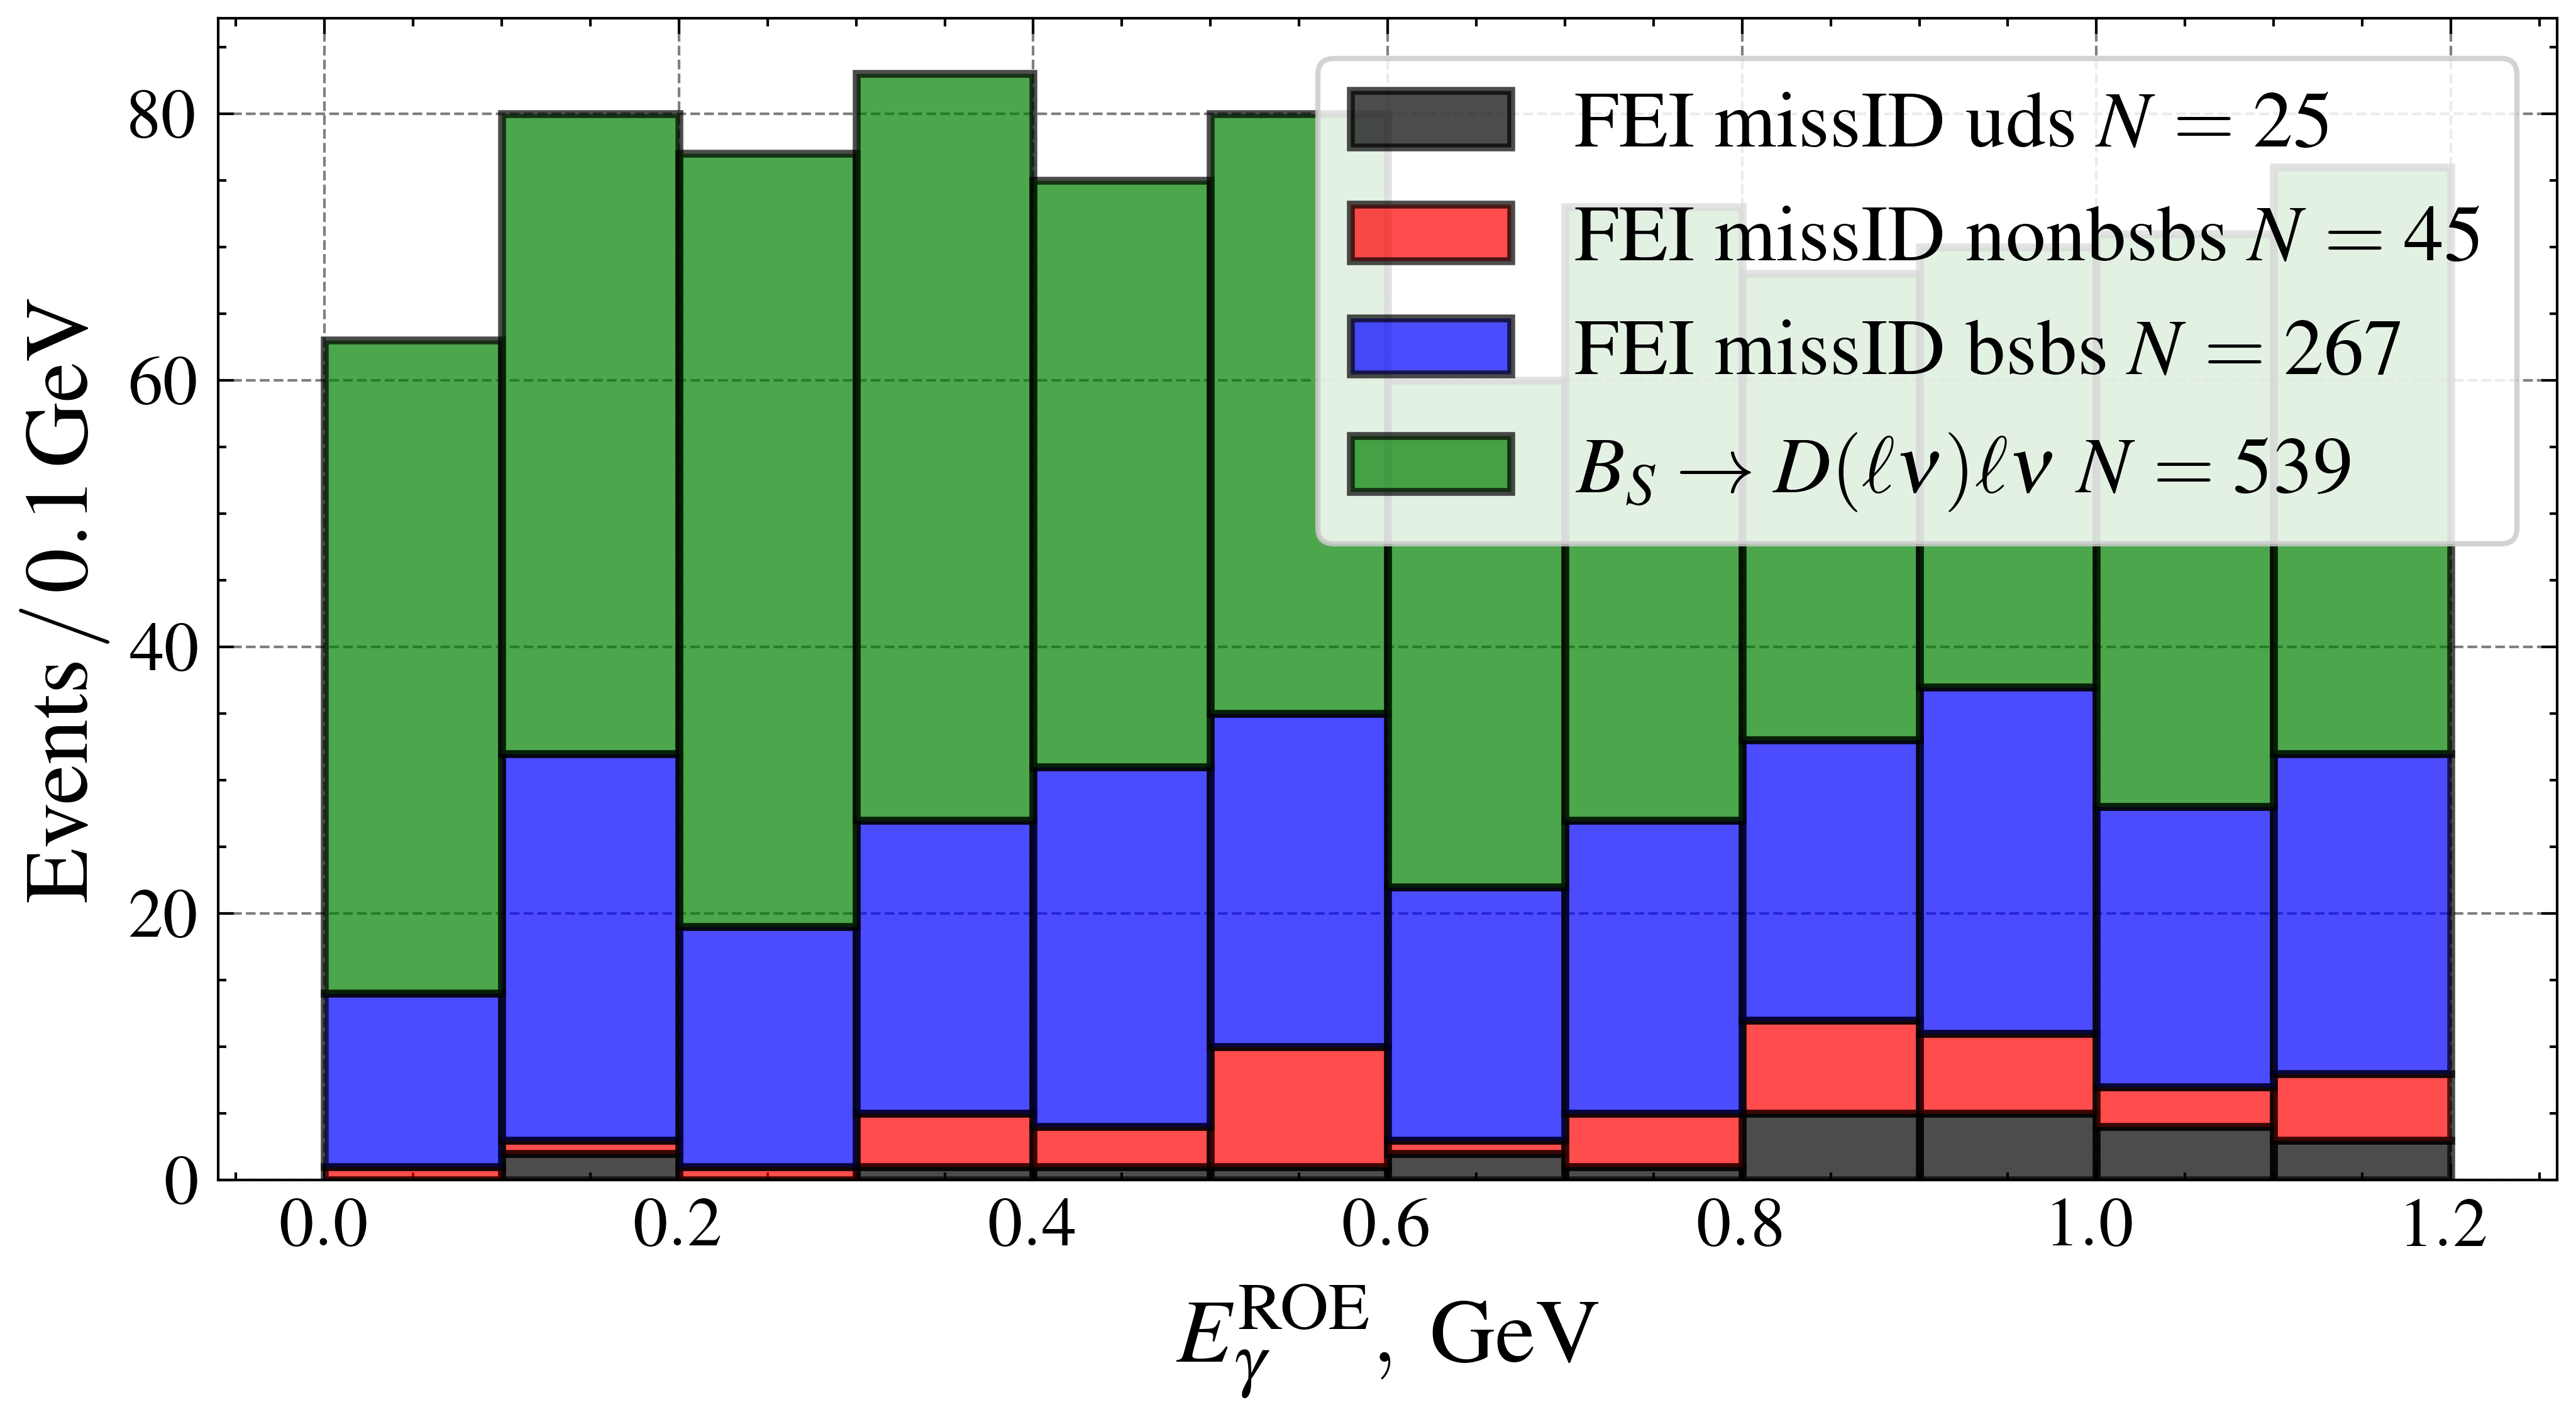

<Figure size 4800x2400 with 0 Axes>

In [8]:
wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

marker_labels = {
    1: r"$B_S \to D(\ell \nu)\ell \nu$",
    2: "nonbsbs",
    3: "Continuum",
    4: "FEI missID uds",
    5: "FEI missID nonbsbs",
    6: "FEI missID bsbs"
}

stack_data = []
stack_labels = []
for marker in sorted(data["marker"].unique(), key=lambda x: (data["marker"] == x).sum()):
    subset = data[data["marker"] == marker]["E_gamma_in_ROE"]
    stack_data.append(subset)
    stack_labels.append(f"{marker_labels[marker]} $N = {len(subset)}$")

# Рисуем
plt.hist(stack_data, bins=bins, stacked=True, alpha=0.7, edgecolor="black", linewidth=1.5, label=stack_labels)


plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}, \ \mathrm{GeV}$")
plt.ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
plt.grid(True)
plt.legend(framealpha = 0.85)
plt.show()
plt.savefig("output/bg_E_ROE_stack")

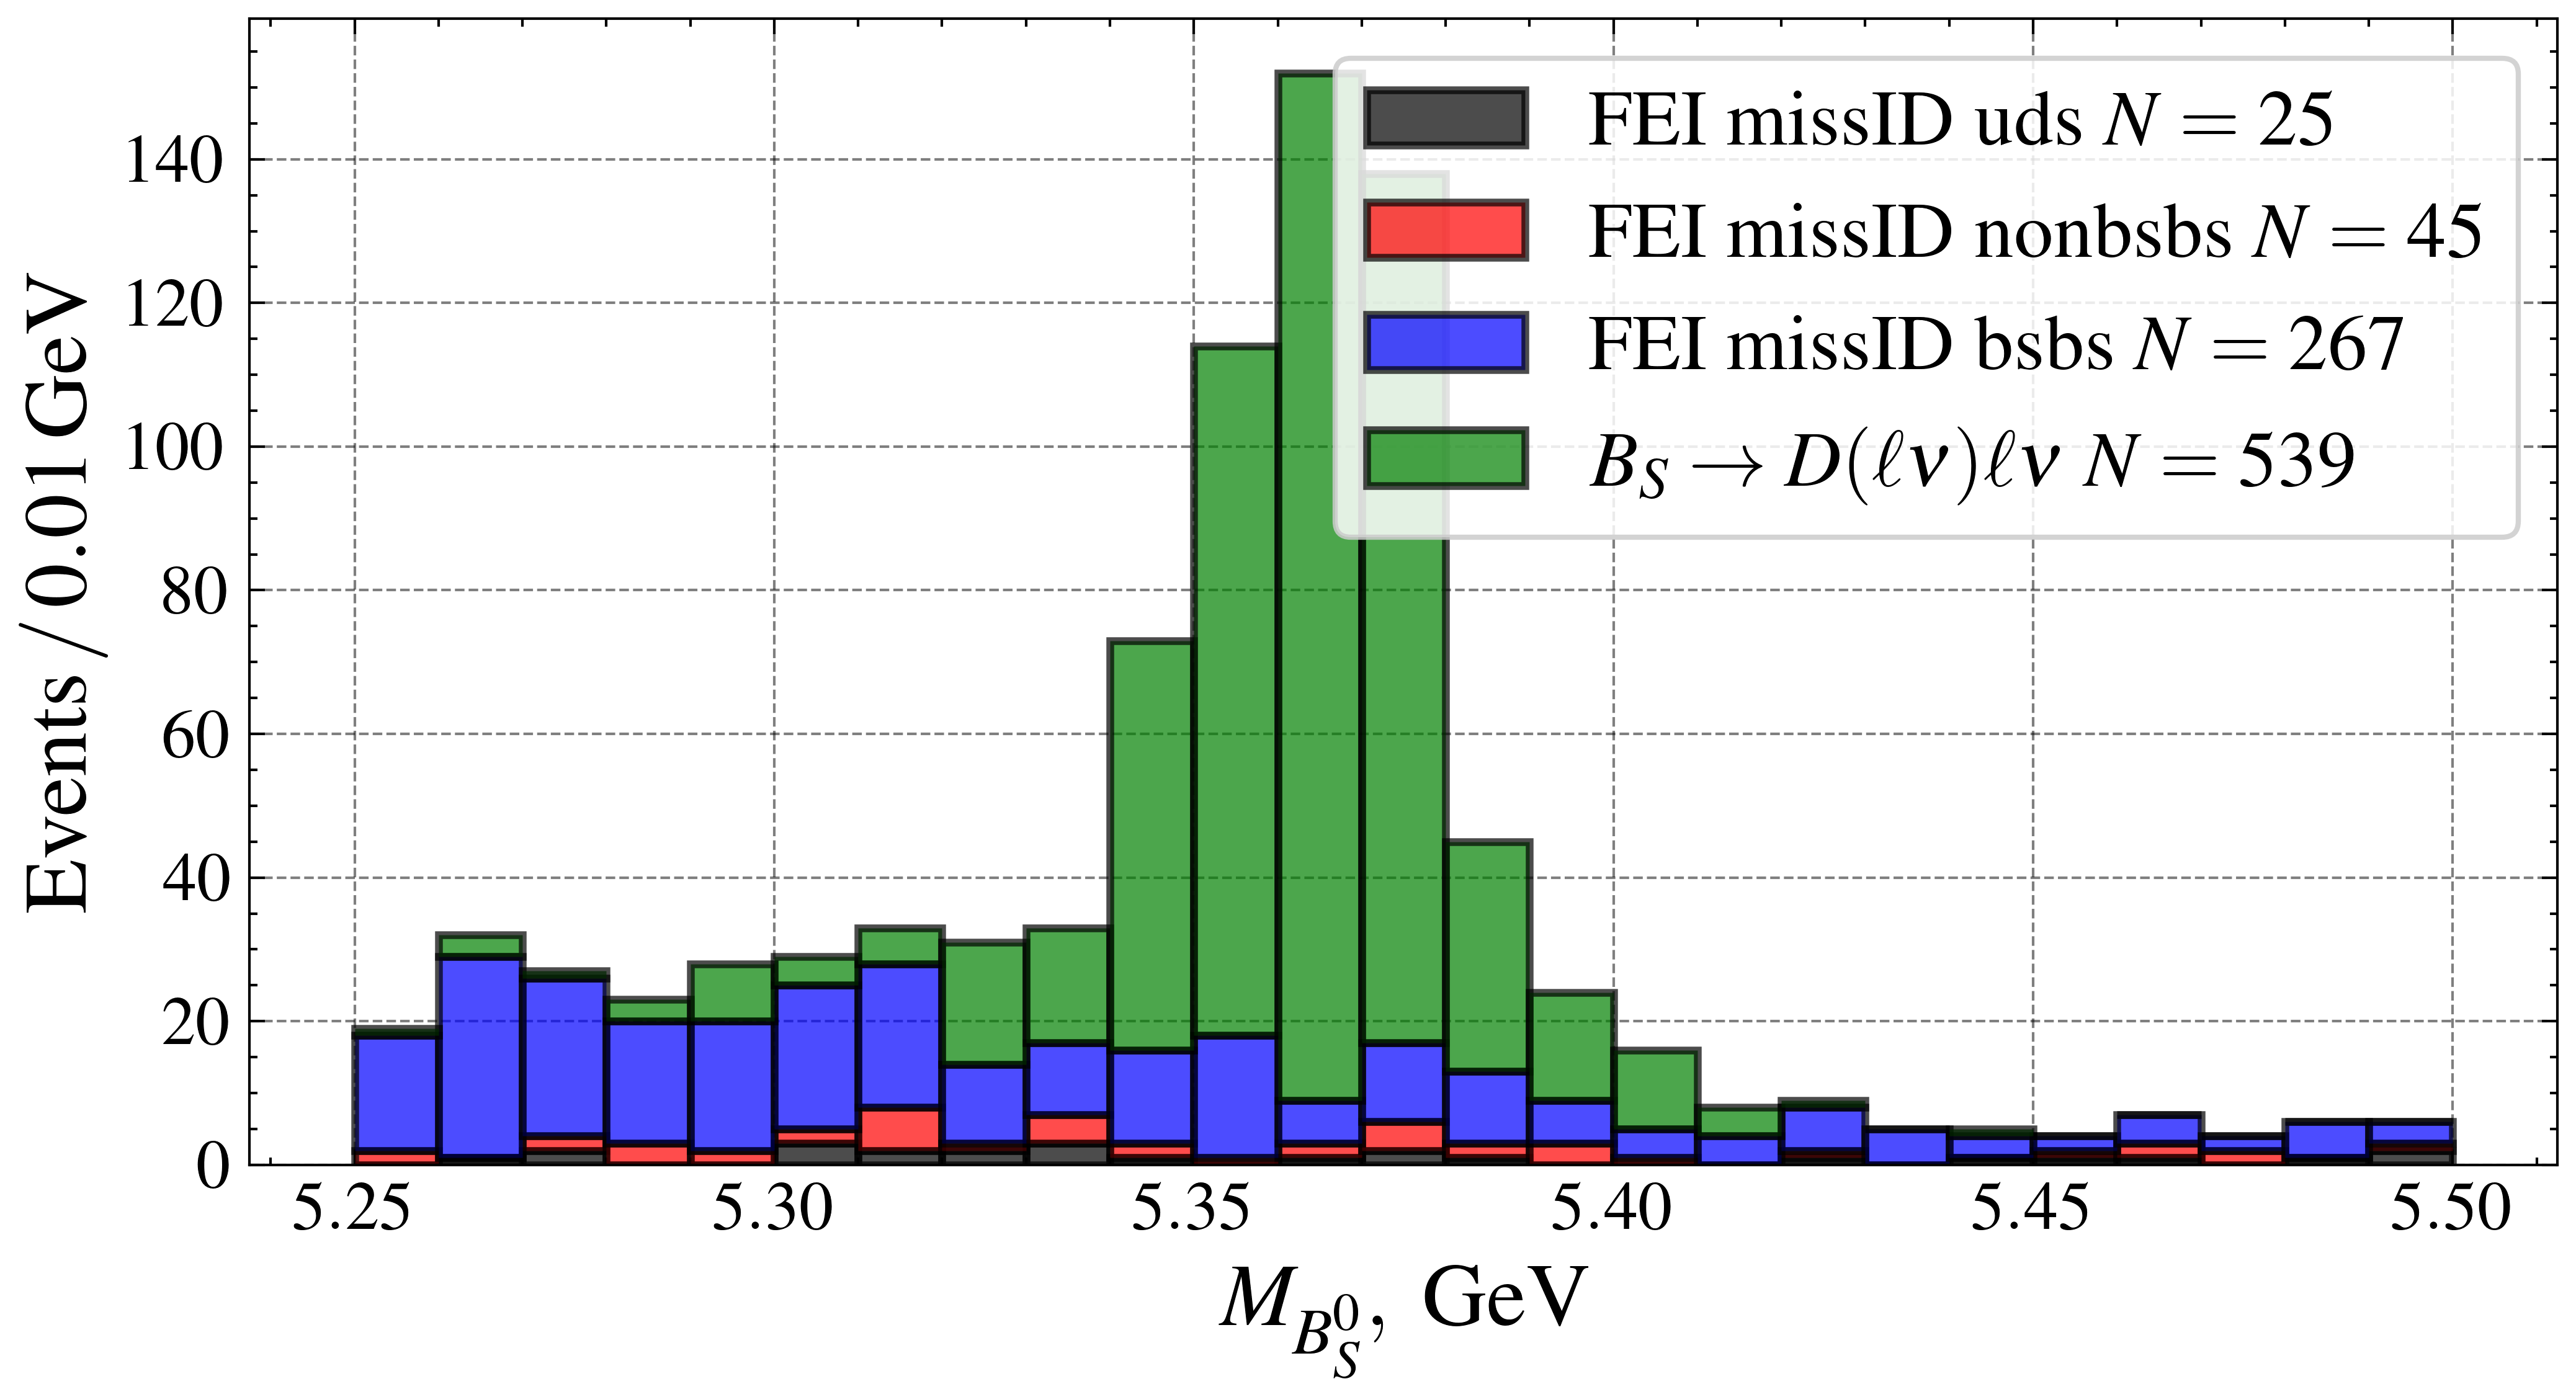

<Figure size 4800x2400 with 0 Axes>

In [9]:
wbin = 0.01
a = 5.25
b = 5.5
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

marker_labels = {
    1: r"$B_S \to D(\ell \nu)\ell \nu$",
    2: "nonbsbs",
    3: "Continuum",
    4: "FEI missID uds",
    5: "FEI missID nonbsbs",
    6: "FEI missID bsbs"
}

stack_data = []
stack_labels = []
for marker in sorted(data["marker"].unique(), key=lambda x: (data["marker"] == x).sum()):
    subset = data[data["marker"] == marker]["M0"]
    stack_data.append(subset)
    stack_labels.append(f"{marker_labels[marker]} $N = {len(subset)}$")

plt.hist(stack_data, bins=bins, stacked=True, alpha=0.7, edgecolor="black", linewidth=1.5, label=stack_labels)


plt.xlabel(r"$M_{B_S^0}, \ \mathrm{GeV}$")
plt.ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
plt.grid(True)
plt.legend(framealpha = 0.85)
plt.show()

plt.savefig("output/bg_M_BS0_stack")

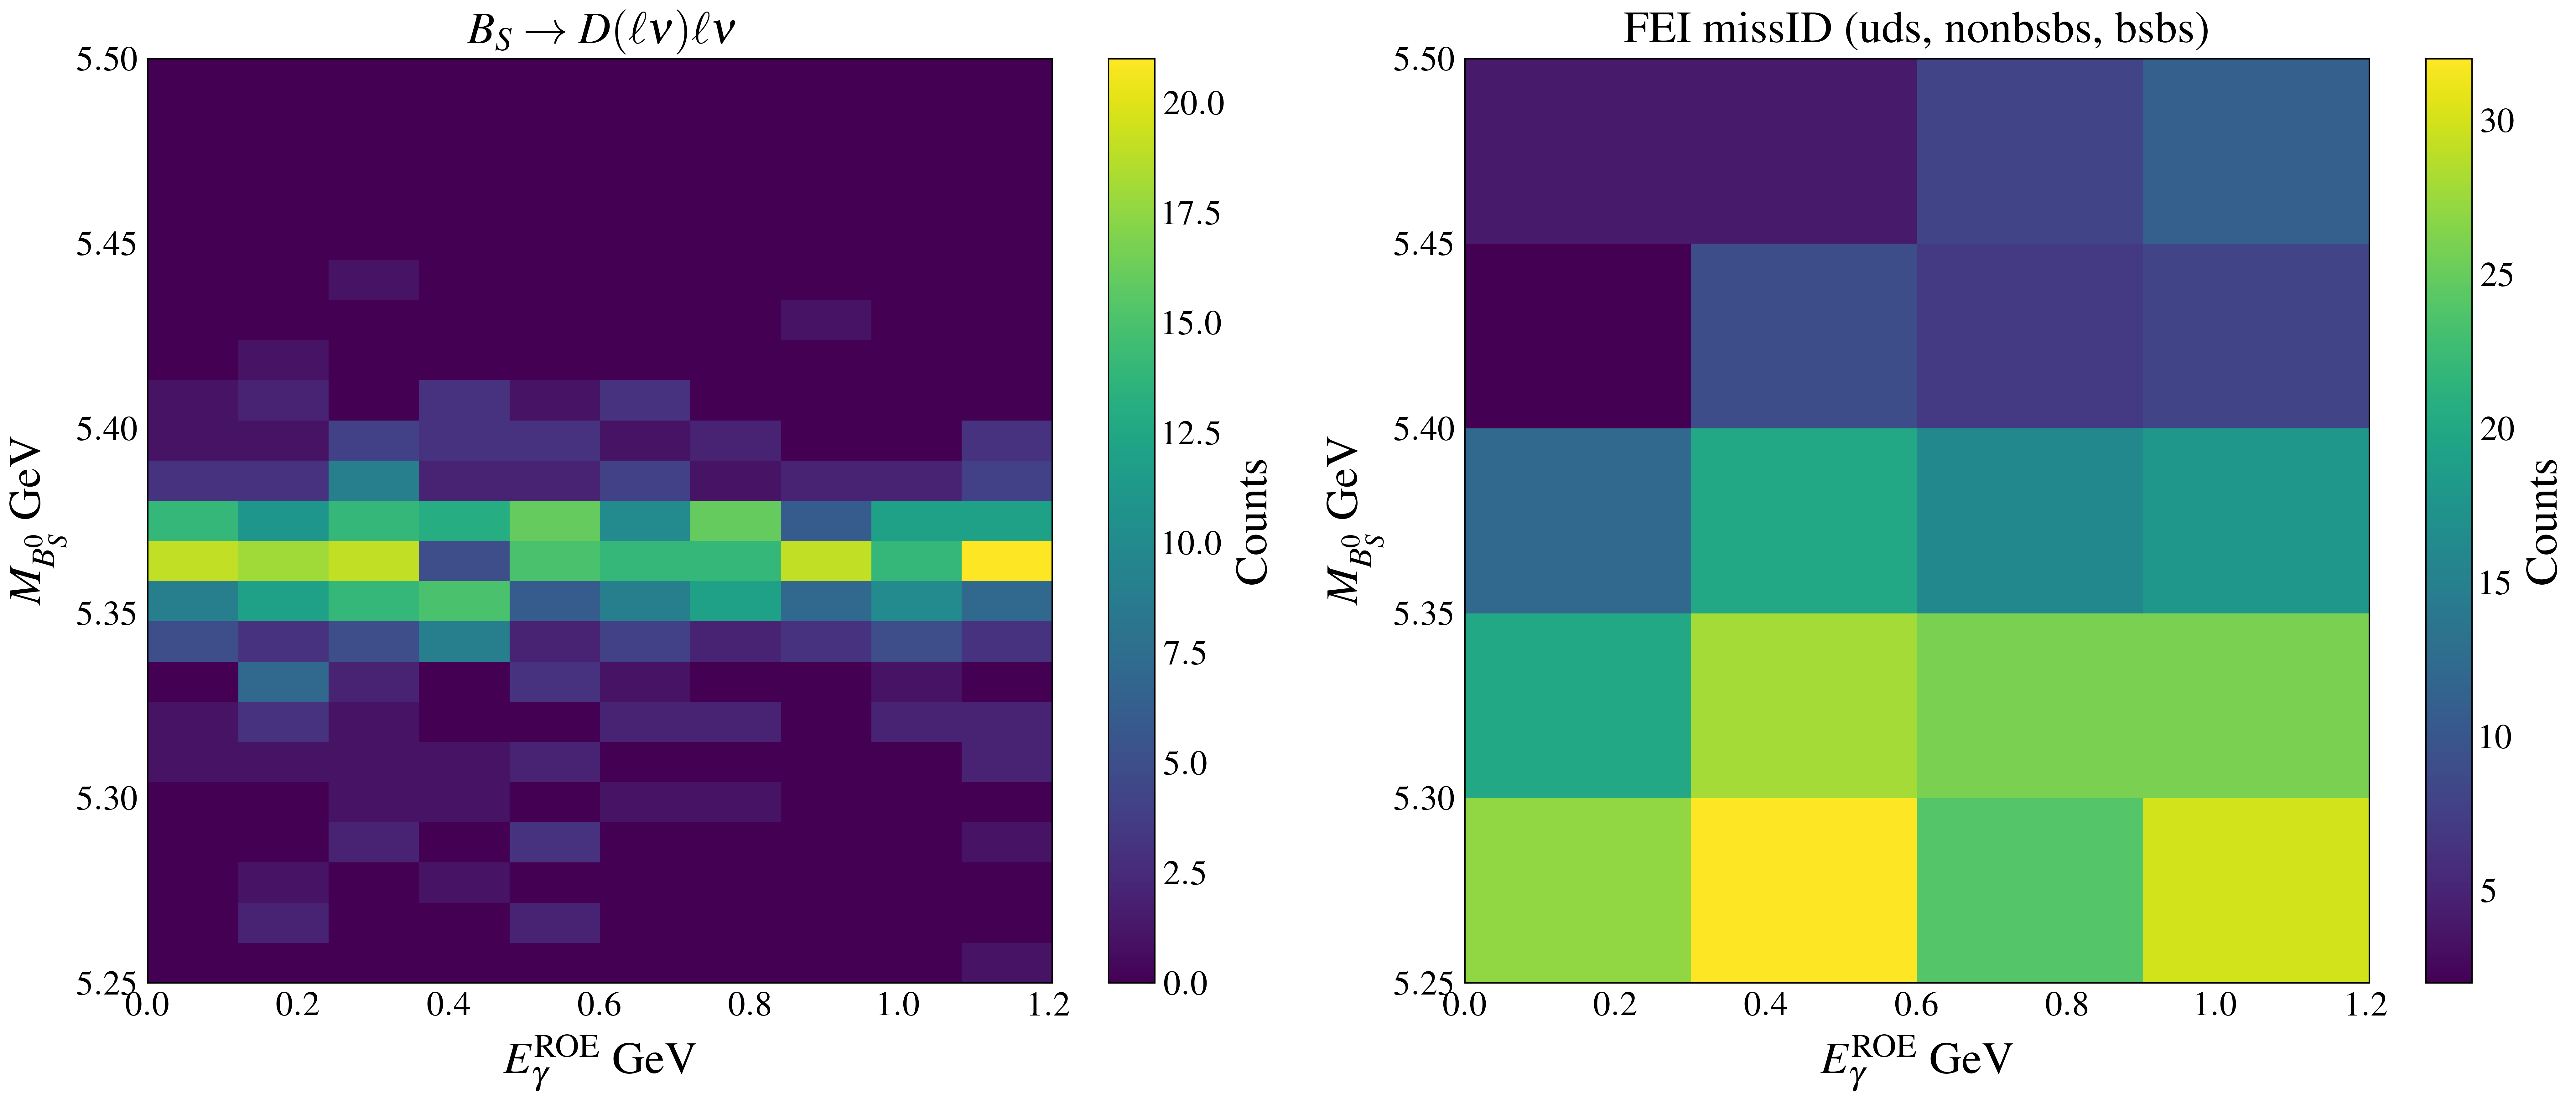

In [ ]:

wbin_x, a_x, b_x = 0.1, 0, 1.2
wbin_y, a_y, b_y = 0.01, 5.25, 5.5
bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))
signal_data = data[data["marker"] == 1]
fei_missid_data = data[data["marker"].isin([4, 5, 6])]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

h_sig = axs[0].hist2d(signal_data["E_gamma_in_ROE"], signal_data["M0"], 
                      bins=[bins_x, bins_y])

bin_centers = [0.5 * (b[:-1] + b[1:]) for b in [bins_x, bins_y]]
bin_centers = np.meshgrid(*bin_centers, indexing='ij')
hist1 = hist_approx()
hist1.put_hist(bin_centers, h_sig[0])


axs[0].set_xlabel(r"$E_\gamma^{\mathrm{ROE}} \ \mathrm{GeV}$")
axs[0].set_ylabel(r"$M_{B_S^0} \ \mathrm{GeV}$")
axs[0].set_title(r"$B_S \to D(\ell \nu)\ell \nu$")
plt.colorbar(h_sig[3], ax=axs[0], label='Counts')

wbin_x, a_x, b_x = 0.2, 0, 1.2
wbin_y, a_y, b_y = 0.01*4, 5.25, 5.5
bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))

h_fei = axs[1].hist2d(fei_missid_data["E_gamma_in_ROE"], fei_missid_data["M0"], 
                      bins=[bins_x, bins_y])

bin_centers = [0.5 * (b[:-1] + b[1:]) for b in [bins_x, bins_y]]

bin_centers = np.meshgrid(*bin_centers, indexing='ij')

hist2 = hist_approx()
hist2.put_hist(bin_centers, h_sig[0])


axs[1].set_xlabel(r"$E_\gamma^{\mathrm{ROE}} \ \mathrm{GeV}$")
axs[1].set_ylabel(r"$M_{B_S^0} \ \mathrm{GeV}$")
axs[1].set_title("FEI missID (uds, nonbsbs, bsbs)")
plt.colorbar(h_fei[3], ax=axs[1], label='Counts')

plt.tight_layout()
plt.savefig("output/bg_hist2d_split")
plt.show()


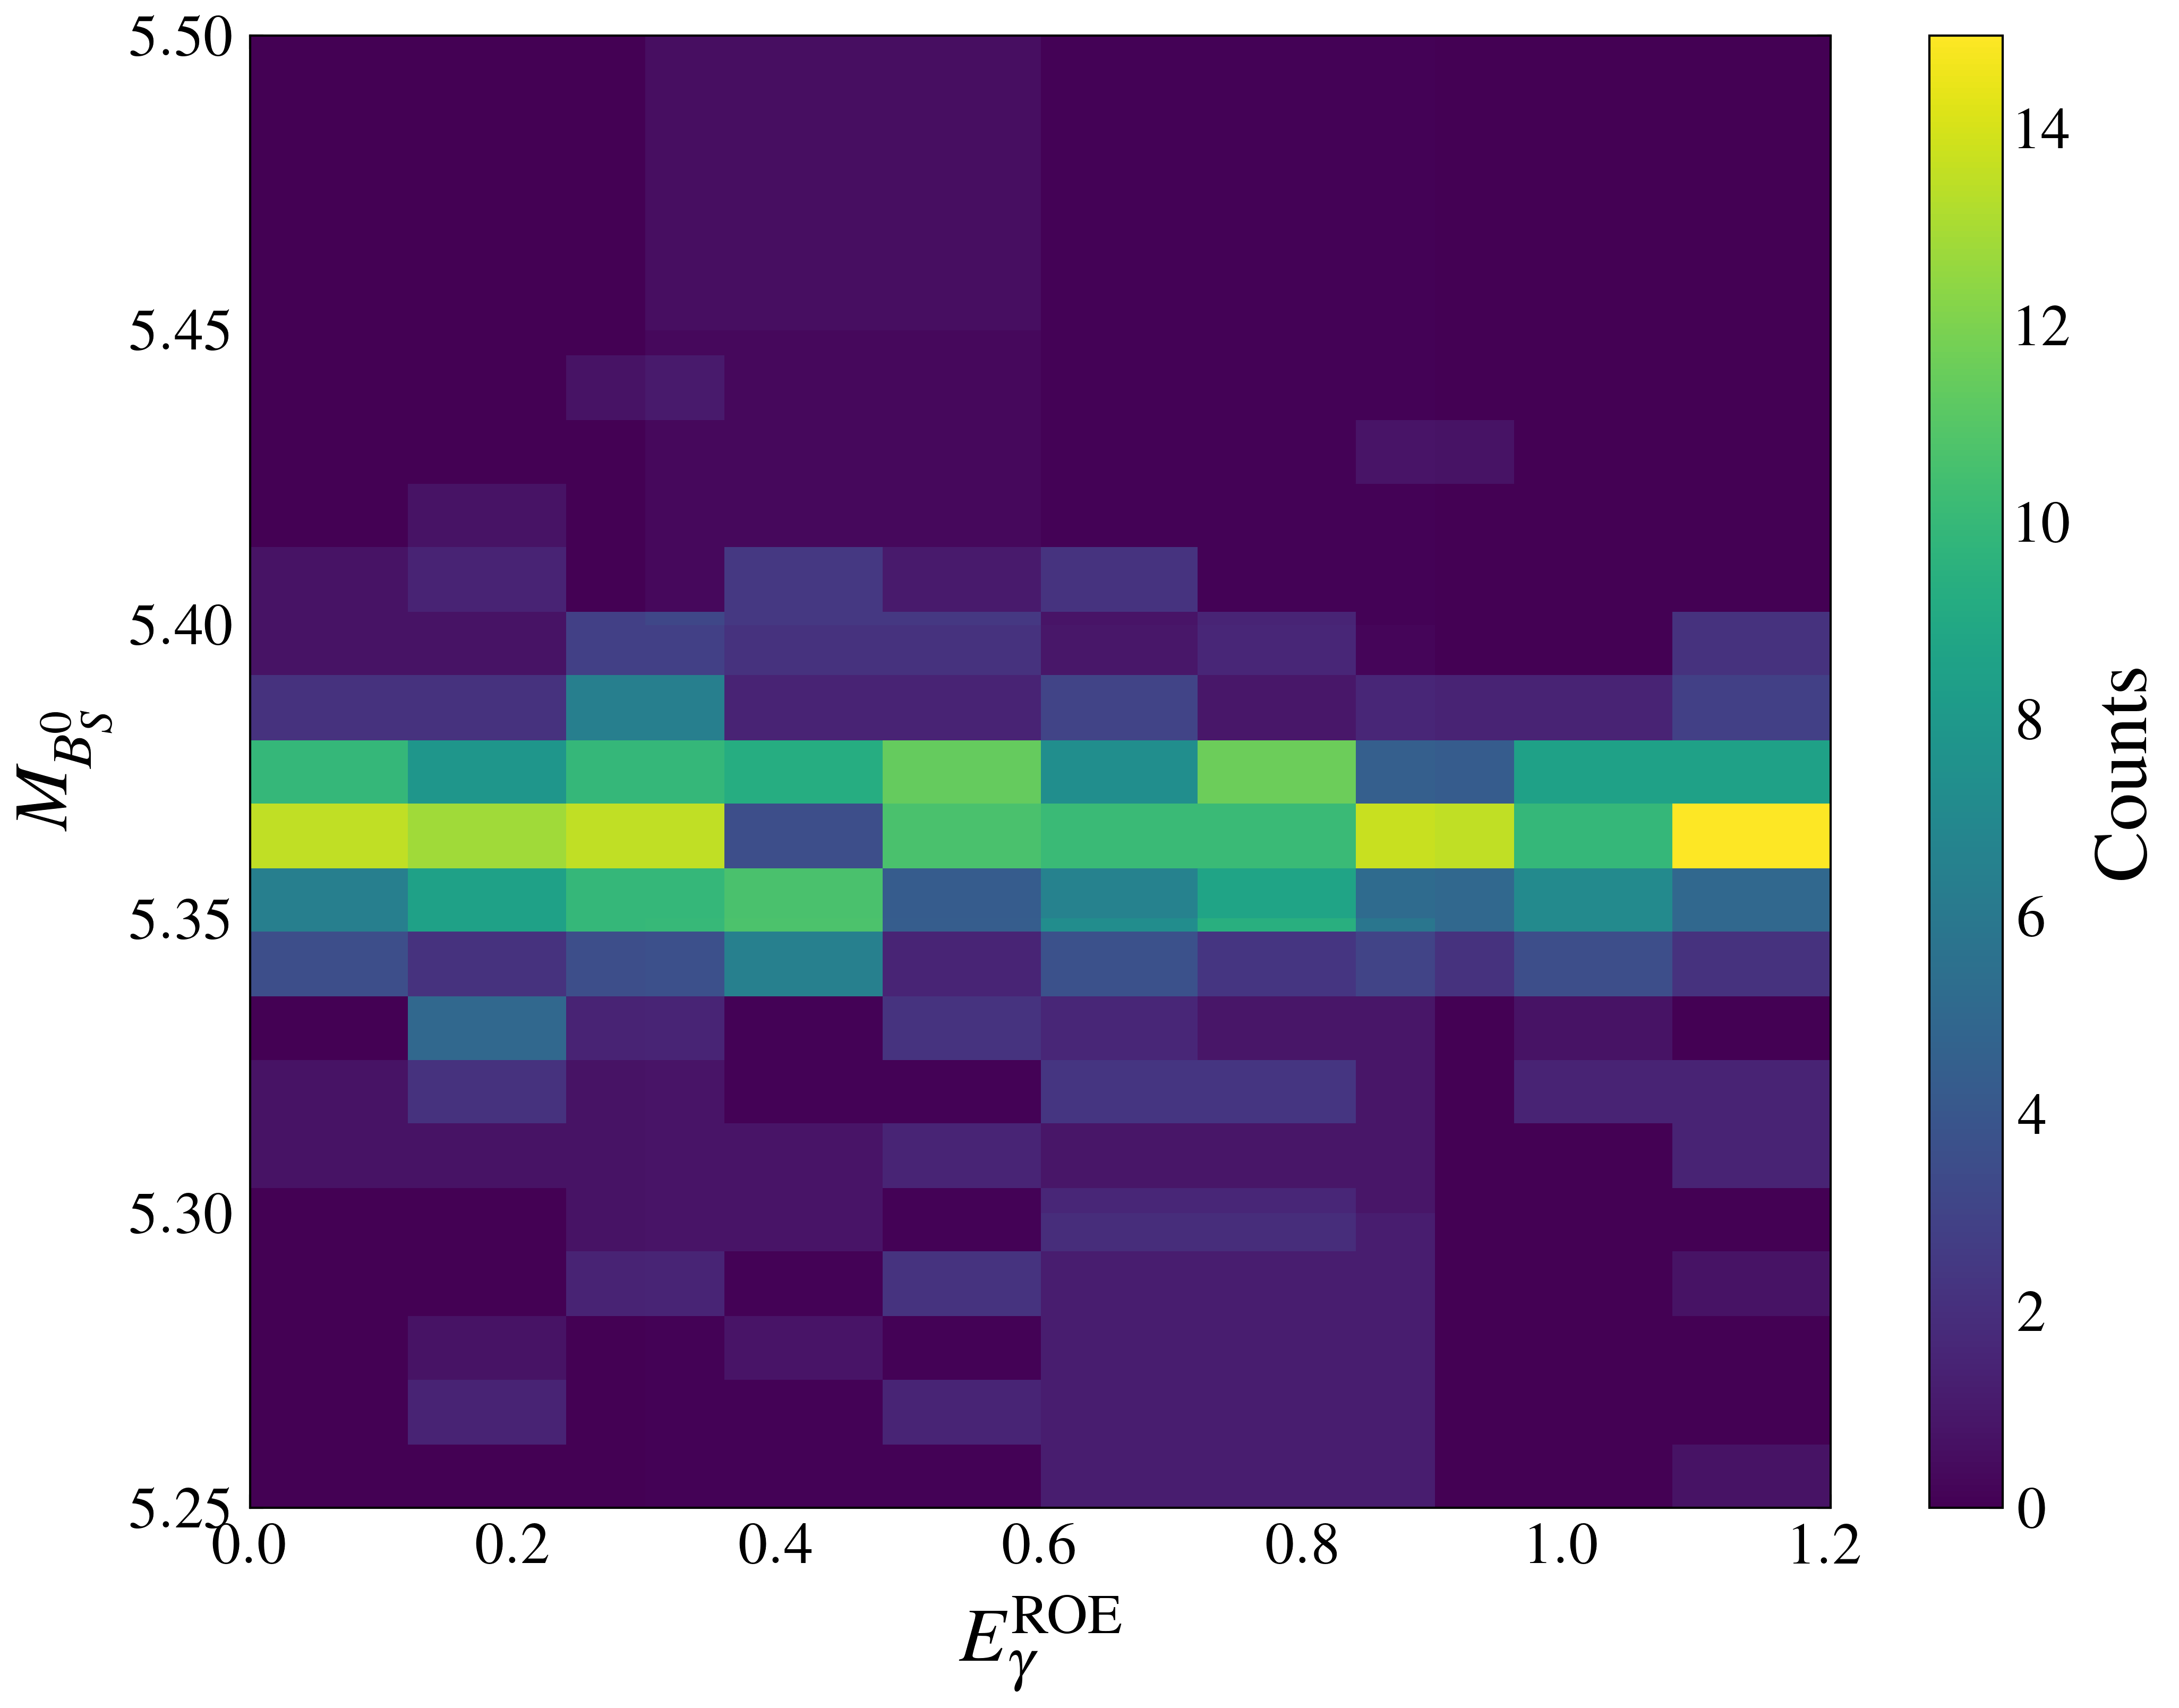

In [11]:
bins_x = np.linspace(a_x, b_x, 1000)
bins_y = np.linspace(a_y, b_y, 1000)
bin_centers = [0.5 * (b[:-1] + b[1:]) for b in [bins_x, bins_y]]
bin_centers = np.meshgrid(*bin_centers, indexing='ij')
counts = hist1.get_pdf(bin_centers)*hist1.N/(hist1.N+hist2.N) + hist2.get_pdf(bin_centers)*hist2.N/(hist1.N+hist2.N)
plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(*bin_centers, counts)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_S^0}$")
plt.colorbar(pmesh, label="Counts")
plt.show()


In [16]:
def gen_toy_nd(pdf_func, bounds, size=10000, grid_points=50):
    ndim = len(bounds)
    samples = []

    grids = [np.linspace(a, b, grid_points) for a, b in bounds]
    meshes = np.meshgrid(*grids, indexing='ij')
    Z = pdf_func(meshes)
    ymax = np.max(Z)

    while len(samples) < size:
        x_trial = [np.random.uniform(a, b) for a, b in bounds]
        y_trial = np.random.uniform(0, ymax)

        # FIX: оборачиваем в массивы
        x_array = [np.array([xi]) for xi in x_trial]

        if y_trial <= pdf_func(x_array):
            samples.append(x_trial)

    return np.array(samples)


In [29]:
toy_pdf = lambda x: hist1.get_pdf(x)*hist1.N/(hist1.N+hist2.N) + hist2.get_pdf(x)*hist2.N/(hist1.N+hist2.N)

ds_toy = gen_toy_nd(toy_pdf, bounds=[[0, 1.2], [5.25, 5.5]], size=int((hist1.N+hist2.N)/6), grid_points=100)

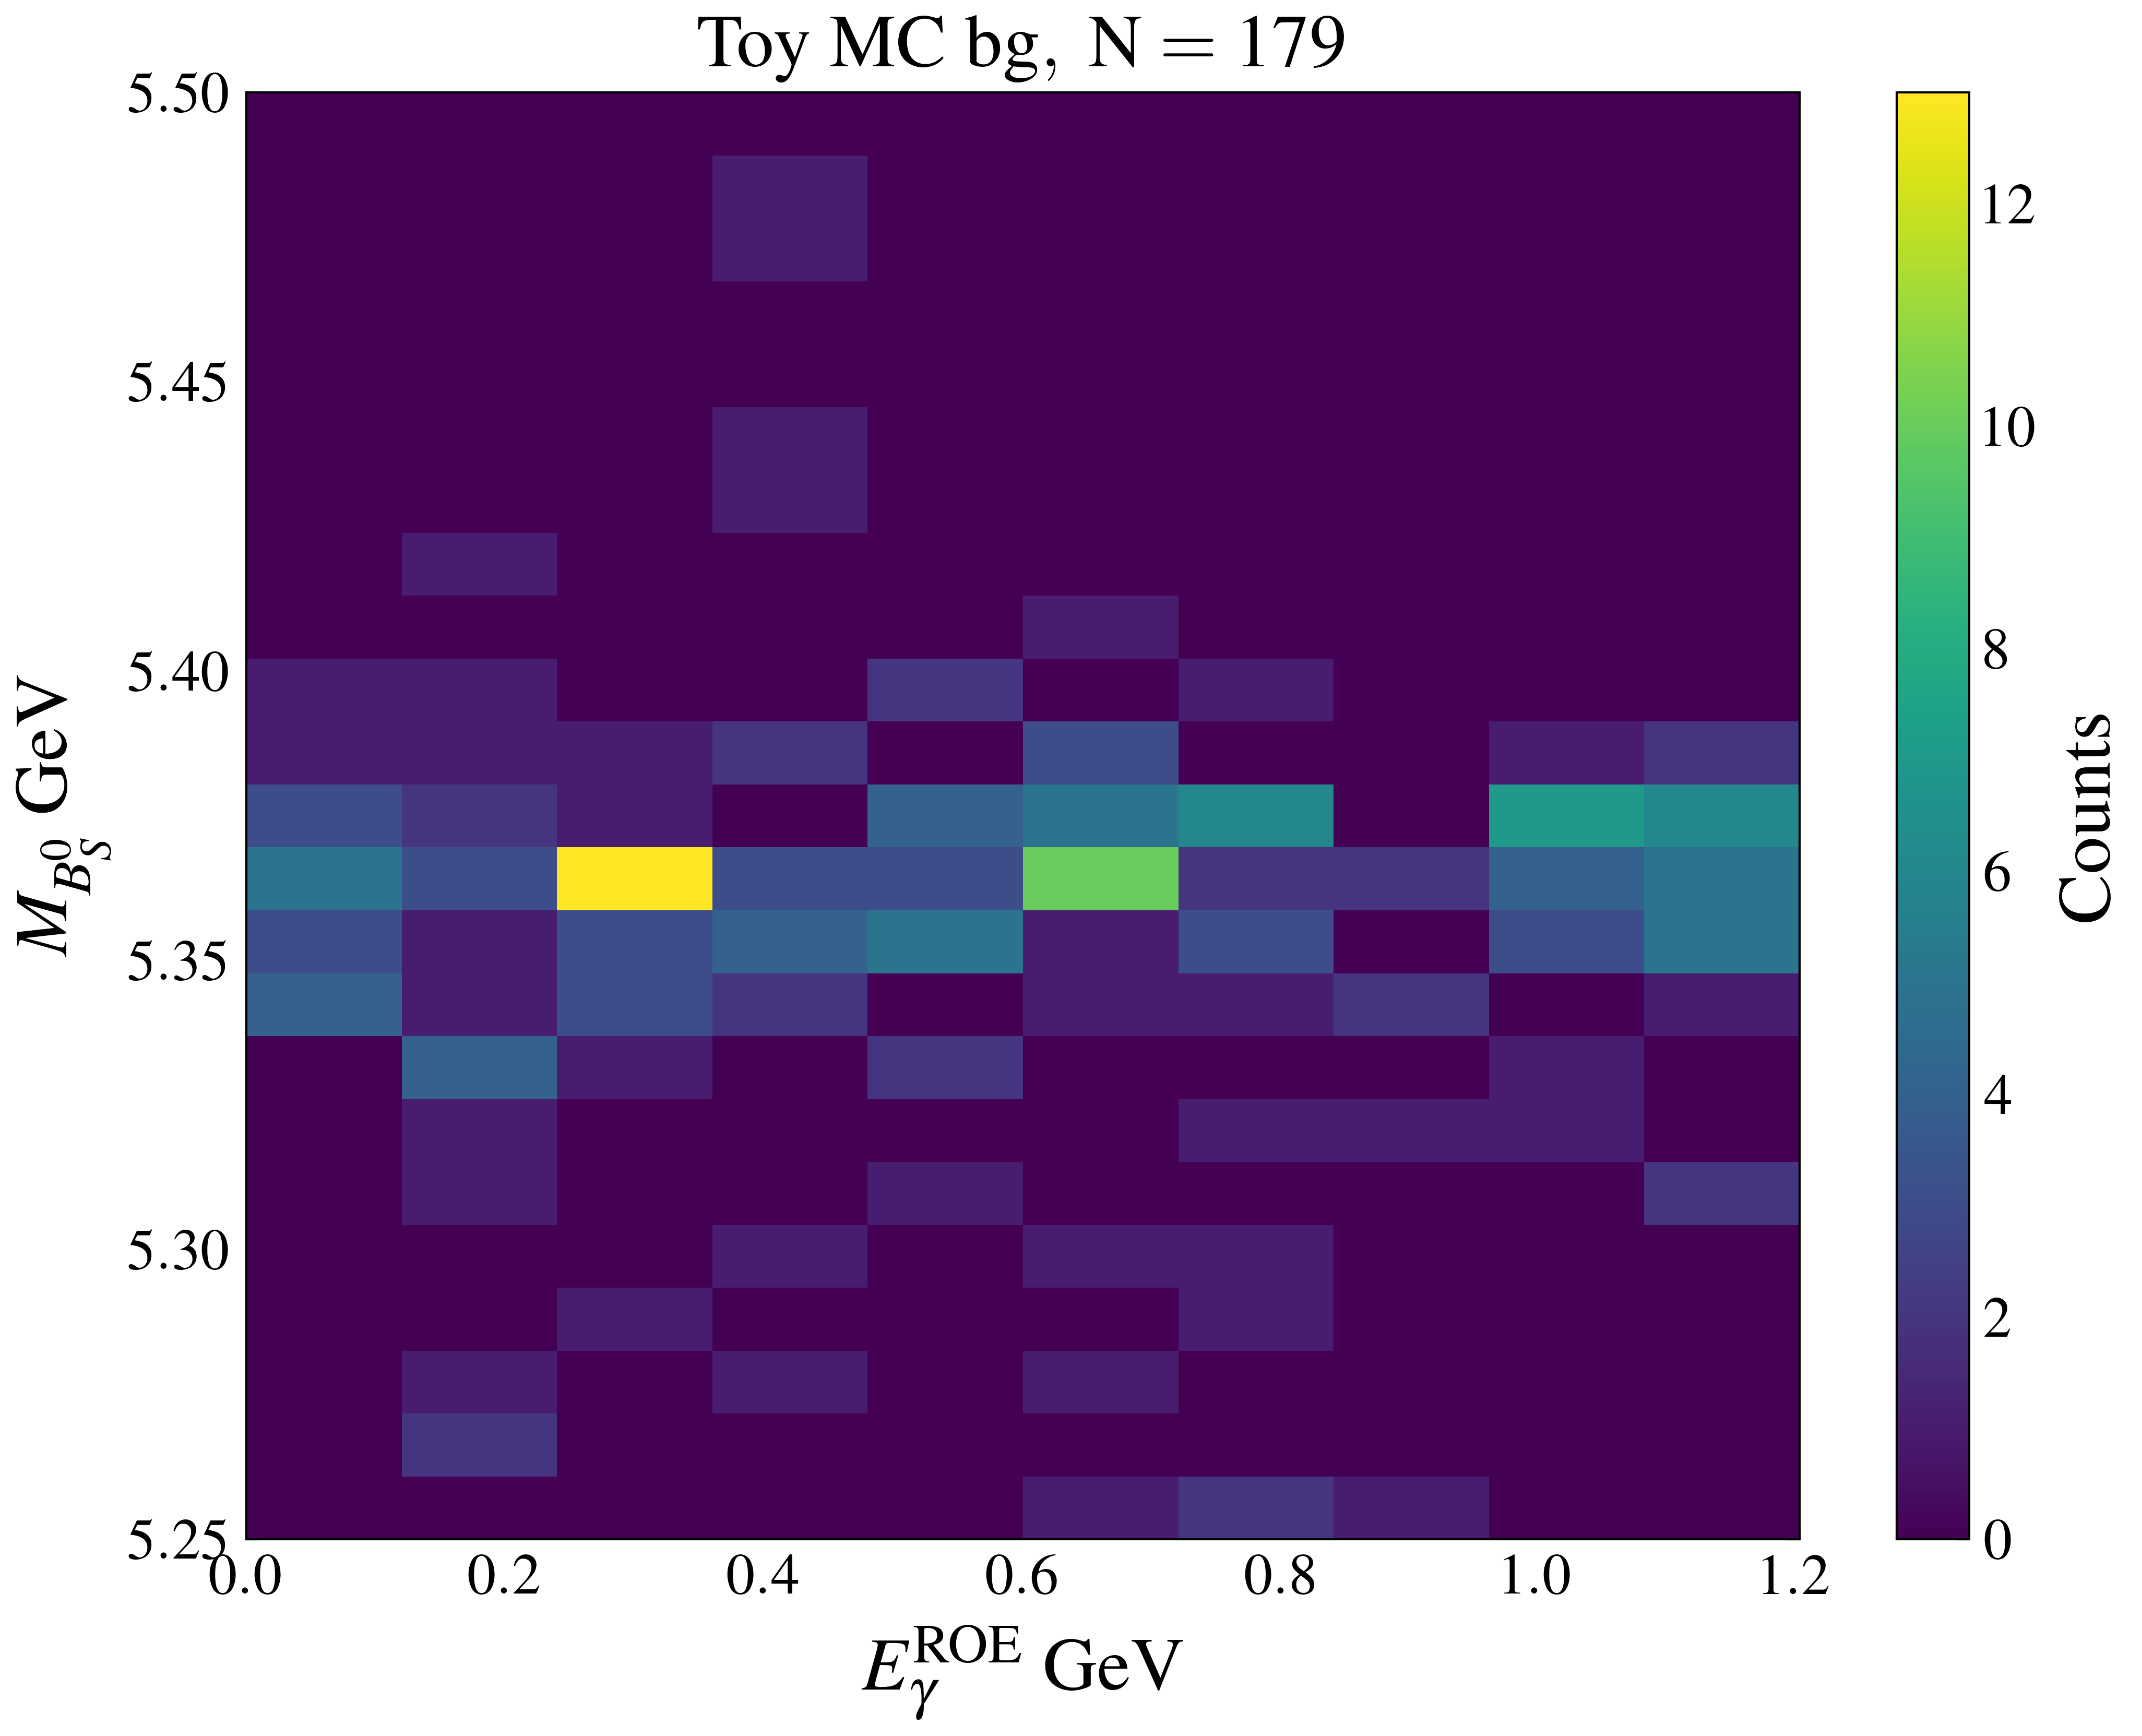

In [35]:

wbin_x, a_x, b_x = 0.1, 0, 1.2
wbin_y, a_y, b_y = 0.01, 5.25, 5.5
bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))

plt.figure(figsize=(8, 6))

h_sig = plt.hist2d(*ds_toy.T, bins=[bins_x, bins_y])

plt.xlabel(r"$E_\gamma^{\mathrm{ROE}} \ \mathrm{GeV}$")
plt.ylabel(r"$M_{B_S^0} \ \mathrm{GeV}$")
plt.title(rf"$\mathrm{{Toy \ MC \ bg, \ N}}={int((hist1.N+hist2.N)/6)}$")
plt.colorbar(h_sig[3], label='Counts')
plt.savefig("output/toy_mc_hist2d")

In [27]:
def gen_toy(pdf_func, a, b, size=10000):
    samples = []
    ymax  = np.max(pdf_func(np.linspace(a, b, 1000)))
    while len(samples) < size:
        x_trial = np.random.uniform(a, b)
        y_trial = np.random.uniform(0, ymax)
        try:
            if y_trial <= pdf_func(x_trial):
                samples.append(x_trial)
        except: continue
    return np.array(samples)


In [39]:
def f_E_g_lep_gamma(x, *, lam, k, theta):
    from scipy.special import gamma
    x = np.where(x <= 0.000001, 0.0001, x)
    x = x*lam
    base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)
    return base
with open("output/sig_fit.json", "r") as f:
    rez0 = dict(json.load(f))
    del rez0["norm"]

In [50]:
def f_E_g_lep_gamma(x, k, theta):
    from scipy.special import gamma
    x = x
    base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)
    return base
def f_sig(x):
    k, theta, mu, sig1, sig2, A = rez0.values()
    return f_E_g_lep_gamma(x[0], k, theta)/np.trapz(f_E_g_lep_gamma(np.linspace(0, 1.2, 1000), k, theta))*(gaussian(x[1], mu, sig1)*A + gaussian(x[1], mu, sig2)*(1 - A))

In [51]:
bsbs = hist_approx().load_hist("output/bsbs.json")
ubs = hist_approx().load_hist("output/ubs.json")

In [91]:
def f_fit (x, *, A0, A1, stak = False):
    if not stak:
        return f_sig(x)*A0 + bsbs.get_pdf(x)*A1 + ubs.get_pdf(x)*(1 - A0 - A1)
    return f_sig(x)*A0, bsbs.get_pdf(x)*A1, ubs.get_pdf(x)*(1 - A0 - A1)

In [90]:
def max_lik(f, x, args0, a=0, b=0, bounds=None, err_need=False):
    if a == b:
        def df(*args):
            current_args = {k: v for k, v in zip(args0.keys(), args)}
            return -2*np.sum(np.log(f(x, **current_args)))
    else:
        def df(*args):
            current_args = {k: v for k, v in zip(args0.keys(), args)}
            return np.trapz(f(np.linspace(a, b, 1000), **current_args), np.linspace(a, b, 1000))-np.sum(np.log(f(x, **current_args)))

    from iminuit import Minuit
    minuit = Minuit(df, *[args0[k] for k in args0], name=list(args0.keys()))

    if bounds:
        for k, bnd in bounds.items():
            minuit.limits[k] = bnd

    minuit.migrad()

    rez = minuit.values.to_dict()
    errs = minuit.errors.to_dict() if err_need else None


    if err_need:
        return rez, errs
    return rez


C:\Users\matve\AppData\Local\Temp\ipykernel_11772\3341519096.py:4: RuntimeWarning: divide by zero encountered in power
  base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)
C:\Users\matve\AppData\Local\Temp\ipykernel_11772\3341519096.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return f_E_g_lep_gamma(x[0], k, theta)/np.trapz(f_E_g_lep_gamma(np.linspace(0, 1.2, 1000), k, theta))*(gaussian(x[1], mu, sig1)*A + gaussian(x[1], mu, sig2)*(1 - A))
C:\Users\matve\AppData\Local\Temp\ipykernel_11772\1608968913.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fit_proj_x = [np.trapz(src, y_centers, axis=1) * wbin_x * np.sum(counts) for src in sources]
C:\Users\matve\AppData\Local\Temp\ipykernel_11772\1608968913.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or o

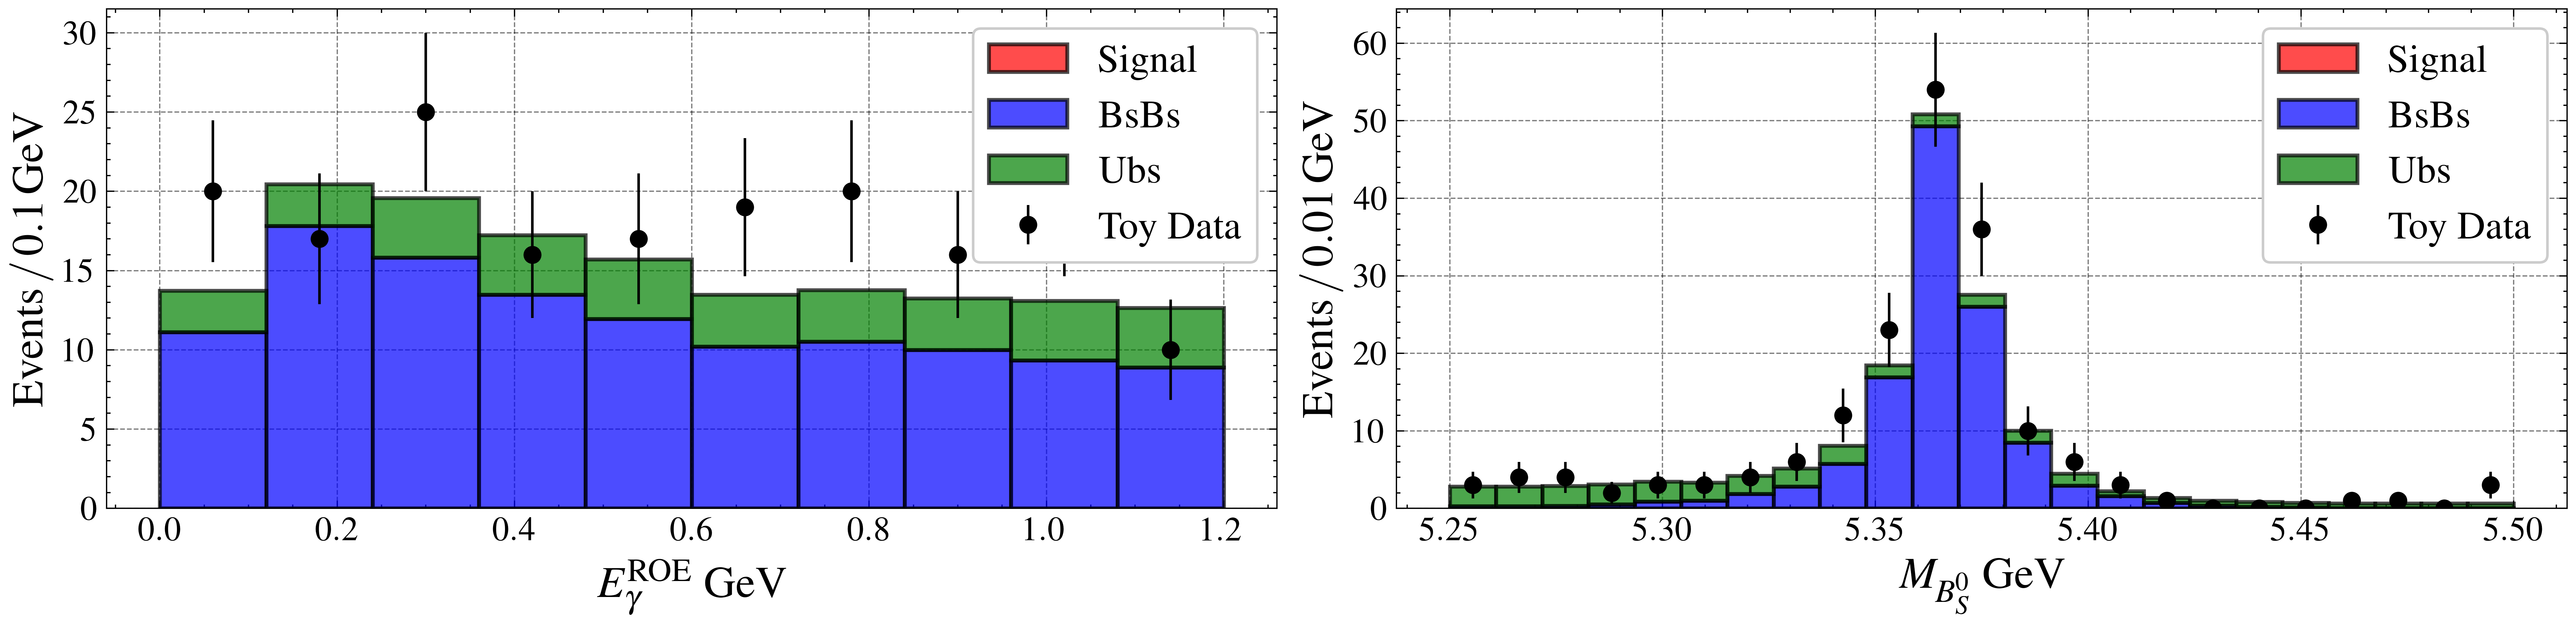

<Figure size 4800x2400 with 0 Axes>

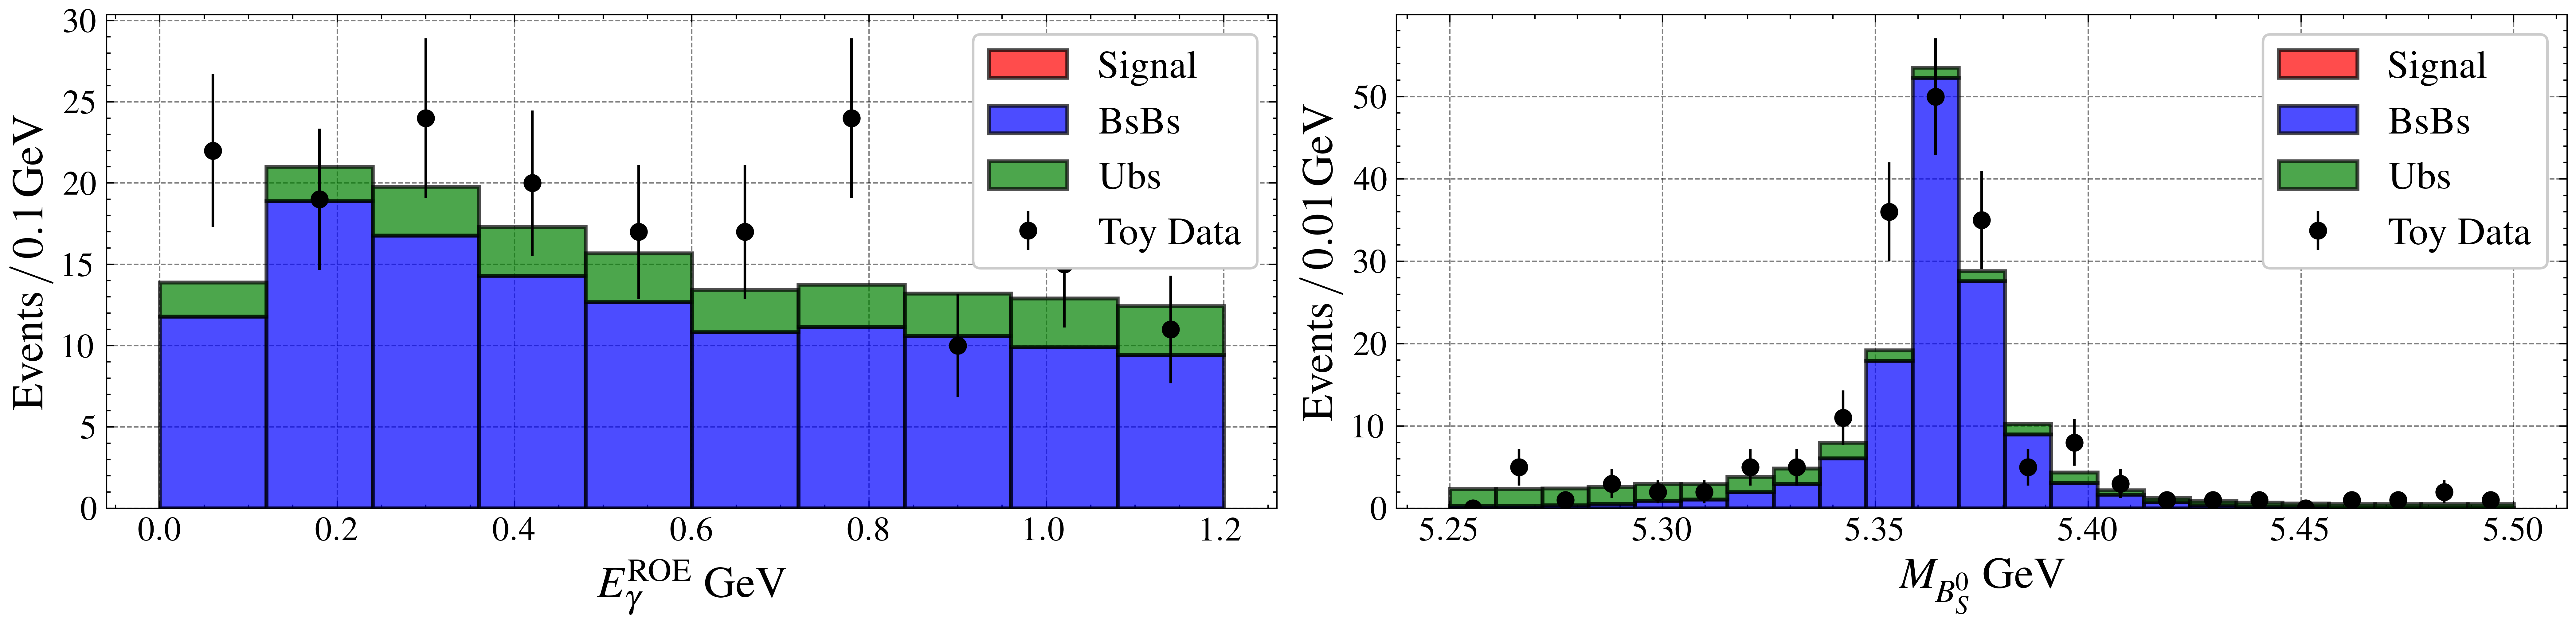

<Figure size 4800x2400 with 0 Axes>

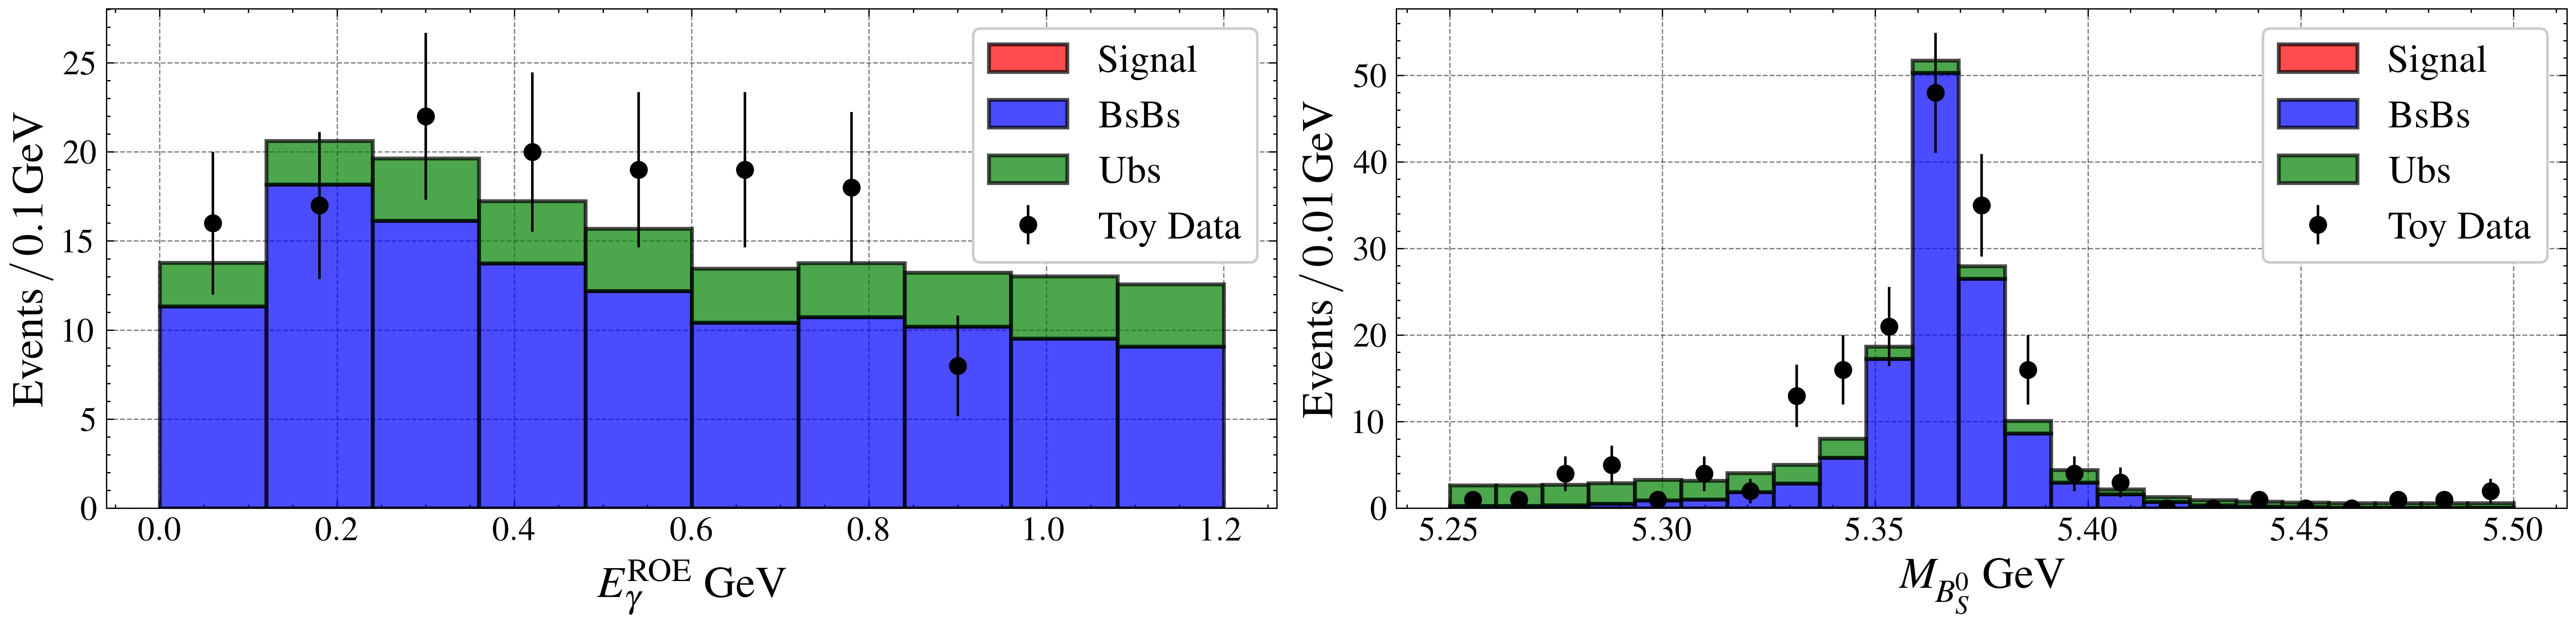

<Figure size 4800x2400 with 0 Axes>

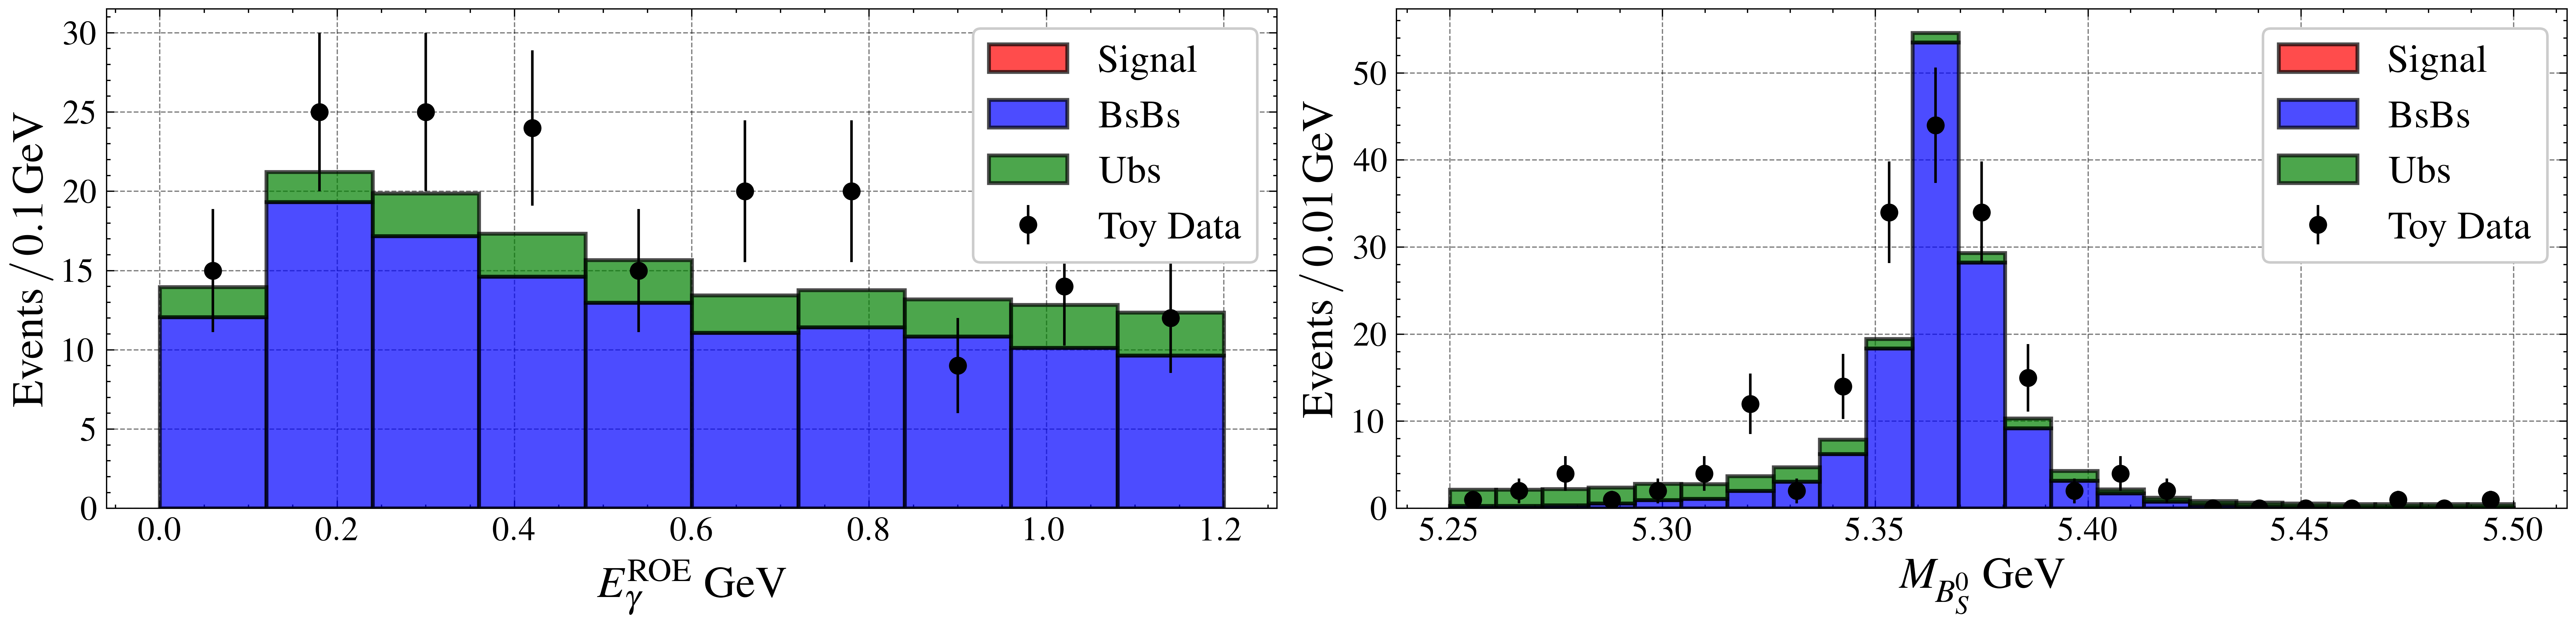

<Figure size 4800x2400 with 0 Axes>

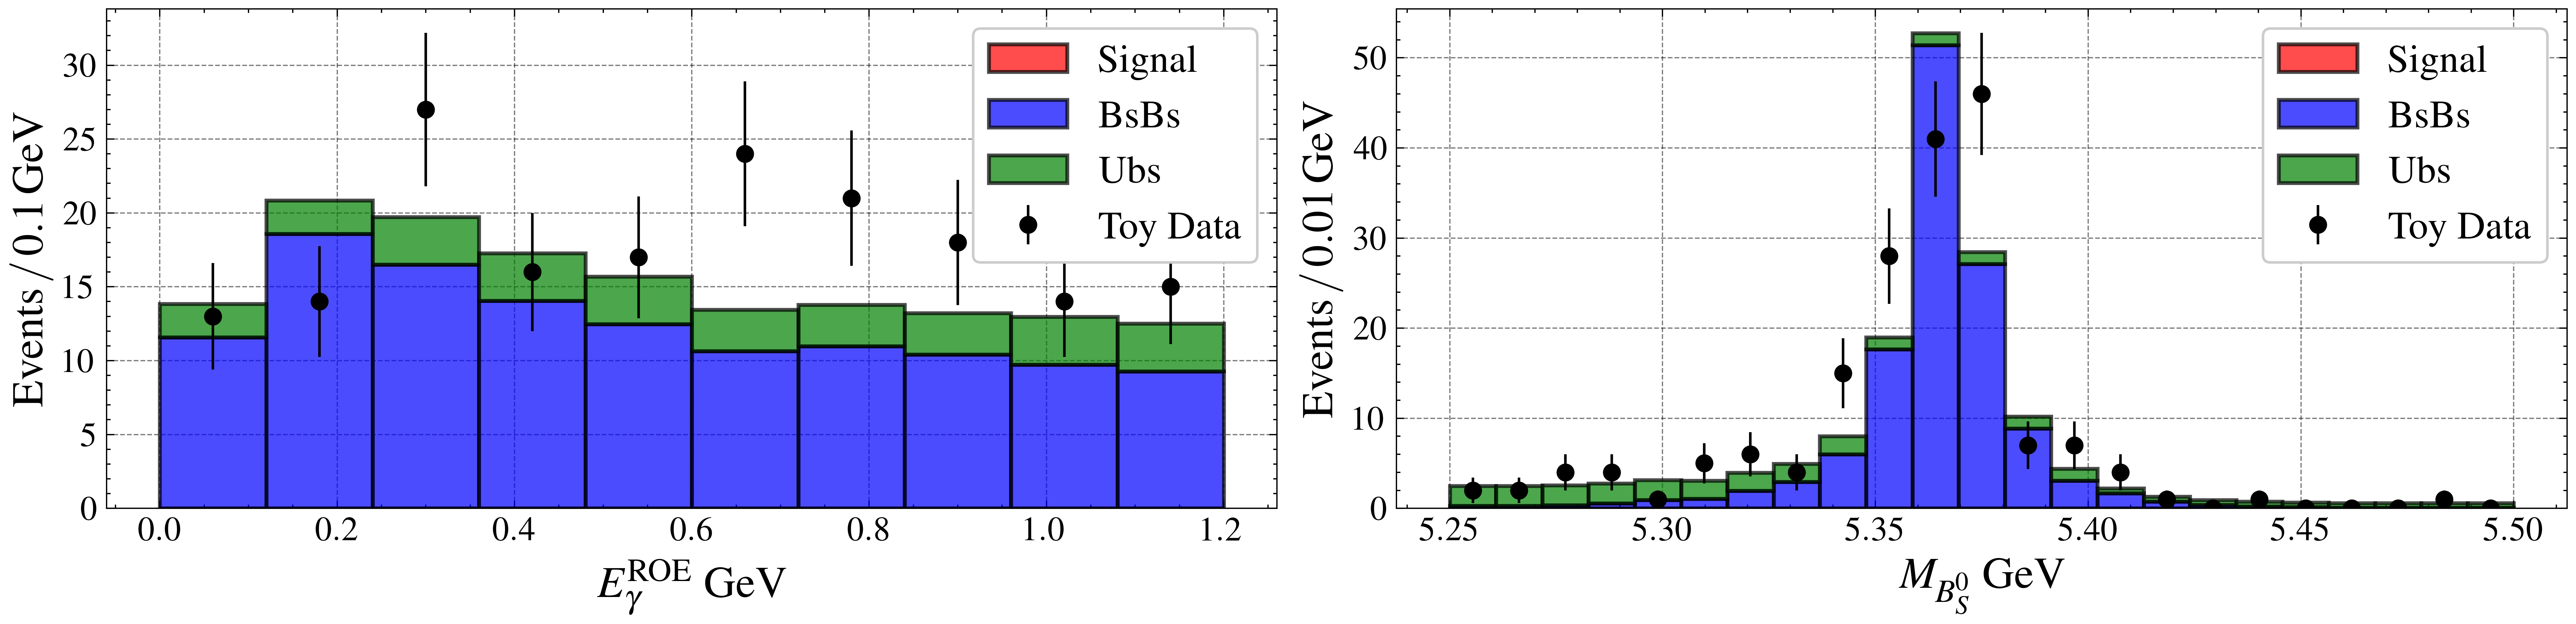

<Figure size 4800x2400 with 0 Axes>

In [112]:
wbin_x, a_x, b_x = 0.1, 0, 1.2
wbin_y, a_y, b_y = 0.01, 5.25, 5.5
bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))

plt_s = (12/1.7, 6/1.7)
pull_s = (12/6, 6/6)

n_toys = 5; i = 0
fit_results = []
A_list = []
for i in range(n_toys):
    toy_sample = gen_toy_nd(toy_pdf, bounds=[[0, 1.2], [5.25, 5.5]], size=int((hist1.N+hist2.N)/6), grid_points=100)
    
    rez = max_lik(
        f_fit,
        toy_sample.T,
        {"A0": 0.05, "A1": 0.9},
        bounds={"A0": (0, 1), "A1": (0, 1)}
    )
    
    fit_results.append(rez)
    A_list.append([rez["A0"], rez["A1"]])

    fig, axs = plt.subplots(1, 2, figsize=(2*plt_s[0], plt_s[1]))


    x_centers = 0.5 * (bins_x[:-1] + bins_x[1:])
    y_centers = 0.5 * (bins_y[:-1] + bins_y[1:])
    X, Y = np.meshgrid(x_centers, y_centers, indexing='ij')

    counts, _ = np.histogram(toy_sample.T[0], bins=bins_x)
    sources = f_fit([X, Y], **rez, stak=True)
    fit_proj_x = [np.trapz(src, y_centers, axis=1) * wbin_x * np.sum(counts) for src in sources]

    ax = axs[0]
    ax.errorbar(x_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Toy Data")
    ax.hist([x_centers]*len(fit_proj_x), bins=bins_x, weights=fit_proj_x, stacked=True, alpha=0.7, edgecolor="black", linewidth=1.5, label=[rf"$\mathrm{{{i}}}$" for _, i in enumerate(["Signal", "BsBs", "Ubs"])])
    ax.set_ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_x}\,\mathrm{{GeV}}$')
    ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE}\ \mathrm{GeV}$')
    ax.legend()

    counts, _ = np.histogram(toy_sample.T[1], bins=bins_y)
    sources = f_fit([X, Y], **rez, stak=True)
    fit_proj_y = [np.trapz(src, x_centers, axis=0) * wbin_y * np.sum(counts) for src in sources]


    ax = axs[1]
    ax.errorbar(y_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Toy Data")
    ax.hist([y_centers]*len(fit_proj_y), bins=bins_y, weights=fit_proj_y, stacked=True, alpha=0.7, edgecolor="black", linewidth=1.5, label=[rf"$\mathrm{{{i}}}$" for _, i in enumerate(["Signal", "BsBs", "Ubs"])])
    ax.set_ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_y}\,\mathrm{{GeV}}$')
    ax.set_xlabel(r'$M_{B_S^0}\ \mathrm{GeV}$')
    ax.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(f"output/toy_mc_fit_{i}.png")


In [ ]:
counts_proj_y = np.sum(counts, axis=0)
    bin_centers_y = bin_centers[1][0, :]
    fit_proj_y = np.sum(f_fit(bin_centers, **rez), axis=0)

    ax = axs[1]
    ax.errorbar(bin_centers_y, counts_proj_y/np.sum(counts_proj_y), yerr=np.sqrt(counts_proj_y)/np.sum(counts_proj_y), fmt='o', label="Data")
    ax.plot(bin_centers_y, fit_proj_y, label="Fit")
    ax.set_ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_y}\,\mathrm{{GeV}}$')
    ax.set_xlabel(r'$M_{B_S^0} \ \mathrm{GeV}$')
    ax.legend()

    plt.tight_layout()
    plt.show()

        
    print(f"A0 = {rez['A0']:.3f}; A1 = {rez['A1']:.3f}")

In [ ]:

wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)//wbin + 2))

n_toys = 1000; i = 0
fit_results = []
A_list = []
while i < n_toys:   
    A = np.random.uniform(0, 1)

    toy_sample = np.concat([gen_toy(dg_pdf, a, b, size=N_bg/6), gen_toy(lambda x: f_E_g_lep_gamma(x, **rez0), a, b, size=int(N_bg/6*A))])

    rez = max_lik(f_fit, toy_sample, {"A" : 0.5,}, bounds={"A": (0, 1)})

    i += 1
    A_list.append(A/(1+A))
    fit_results.append(rez["A"])


C:\Users\matve\AppData\Local\Temp\ipykernel_16024\2932709250.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_fit = lambda x, *, A: f_E_g_lep_gamma(x, **rez0)/np.trapz(f_E_g_lep_gamma(np.linspace(0, 1.2, 1000), **rez0), np.linspace(0, 1.2, 1000)) * np.abs(A) + dg_pdf(x) * np.abs(1 - A)


In [ ]:
A_list = np.array(A_list)
fit_results = np.array(fit_results)

In [ ]:
errors = fit_results - A_list
mean = np.mean(errors)
error_std = np.std(errors, ddof=1)

print(f"Error: {mean:.4f} +/- {error_std:.4f}")

Error: -0.0012 +/- 0.0572
